In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from datetime import date
import yfinance
from helper_methods import get_stock_prices_from_db, get_stock_coint_pairs_from_db, TRAINING_DATE_RANGE, TESTING_DATE_RANGE

Creation of DB Tables


In [32]:
# IMPORTANT: THIS STEP WAS ALREADY DONE. THIS IS A VERY TIME CONSUMING CODE BLOCK
# DO NO UNCOMMENT AND RERUN
# from seed_db import seed_stock_info, seed_stock_coint_pairs
# seed_stock_info()
# seed_stock_coint_pairs()

These two functions create two database tables which we can access as a DataFrame.

One DF has all the Stock Prices over the time period:


In [33]:
stock_price_df = get_stock_prices_from_db()
stock_price_df.sample(5)

,id,ticker,sector,price,date
171616,171617,WSO,industrials,256.79,2022-02-10
59906,59907,BAX,healthcare,82.00,2020-03-02
75680,75681,TEVA,healthcare,12.84,2020-06-05
77949,77950,RDY,healthcare,71.72,2021-06-14
101852,101853,UNP,industrials,222.67,2023-08-21


The other DF contains all the coint pairs that were identified.


In [34]:
stock_coint_df = get_stock_coint_pairs_from_db()
stock_coint_df.sample(5)

,id,stock_one,stock_two,pvalue,sector,ratio_stationarity
702,703,HUM,NVO,0.04490,healthcare,0.40671
1228,1229,JBHT,WSO,0.01508,industrials,0.00197
932,933,MTD,TEVA,0.01269,healthcare,0.64036
731,732,ALC,MRNA,0.04573,healthcare,0.48506
1266,1267,BAH,UPS,0.04823,industrials,0.65761


In [35]:
index_of_chosen_pair = 0

stock_one, stock_two = stock_coint_df.sort_values(by=['pvalue', 'ratio_stationarity']).iloc[index_of_chosen_pair][[
    'stock_one', 'stock_two']].to_numpy()
stock_one, stock_two

('PODD', 'RGEN')

In [36]:
pair_stock_price_df = stock_price_df[stock_price_df['ticker'].isin([
                                                                   stock_one, stock_two])]


def gen_date(str_date): return date(*[int(n) for n in str_date.split('-')])


train_start_date = gen_date(TRAINING_DATE_RANGE[0])
train_end_date = gen_date(TRAINING_DATE_RANGE[1])
test_start_date = gen_date(TESTING_DATE_RANGE[0])
test_end_date = gen_date(TESTING_DATE_RANGE[1])
training_df = pair_stock_price_df[(pair_stock_price_df['date'] >= train_start_date) & (
    pair_stock_price_df['date'] <= train_end_date)]
training_df = training_df.set_index('date')

test_df = pair_stock_price_df[(pair_stock_price_df['date'] >= test_start_date) & (
    pair_stock_price_df['date'] <= test_end_date)]

test_df = test_df.set_index('date')

In [37]:
train_stock_one_price_series = training_df[training_df['ticker']
                                           == stock_one]['price']
train_stock_two_price_series = training_df[training_df['ticker']
                                           == stock_two]['price']

test_stock_one_price_series = test_df[test_df['ticker']
                                      == stock_one]['price']
test_stock_two_price_series = test_df[test_df['ticker']
                                      == stock_two]['price']

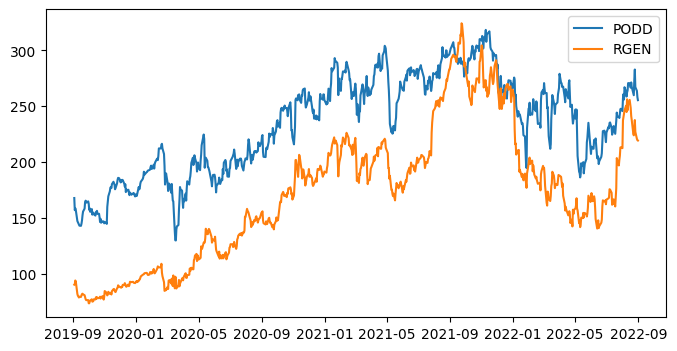

In [38]:
def plot_stock_pair(series_one, label_one, series_two, label_two):
    _fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(series_one, label=label_one)
    ax.plot(series_two, label=label_two)
    ax.legend()
    plt.show()


plot_stock_pair(train_stock_one_price_series, stock_one,
                train_stock_two_price_series, stock_two)

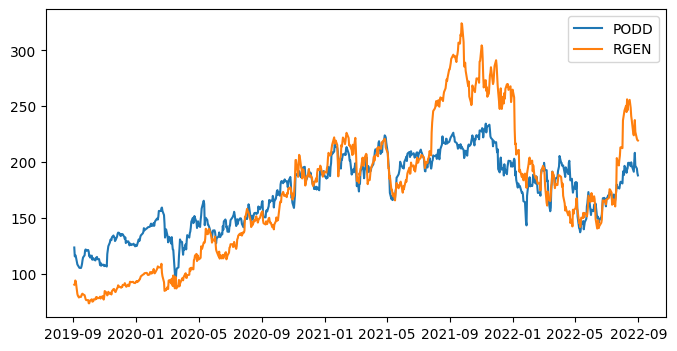

In [39]:
def plot_stock_one_adjusted_pair(series_one, label_one, series_two, label_two):
    series_one_adjusted = series_one / \
        (np.mean(series_one) / np.mean(series_two))
    plot_stock_pair(series_one_adjusted, label_one, series_two, label_two)


plot_stock_one_adjusted_pair(train_stock_one_price_series, stock_one,
                             train_stock_two_price_series, stock_two)

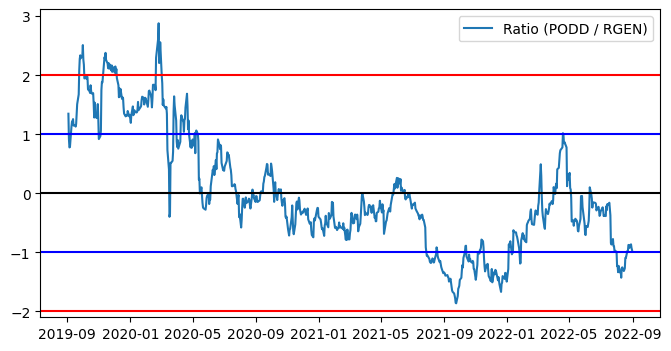

In [40]:
def plot_stock_pair_ratio(series_one, label_one, series_two, label_two):
    # Use ratios to calculate spread
    ratio = series_one / series_two

    # Normalize the series
    z_score = (ratio - ratio.mean()) / ratio.std()

    # Note: need to change labels
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(z_score, label=f'Ratio ({label_one} / {label_two})')
    plt.axhline(z_score.mean(), color='black')

    # 68% of the data lies within 1 standard deviation
    plt.axhline(1.0, color='blue')
    plt.axhline(-1.0, color='blue')

    # 95% of data lies within 2 standard deviations from mean
    plt.axhline(2.0, color='red')
    plt.axhline(-2.0, color='red')

    ax.legend()
    plt.show()


plot_stock_pair_ratio(train_stock_one_price_series, stock_one,
                      train_stock_two_price_series, stock_two)

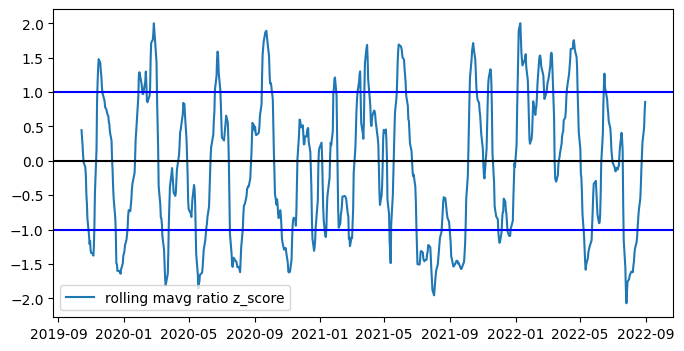

In [41]:
def plot_mvg_avg_ratio(price_ratio_series):
    # 1 day moving avg represents our current mean
    mavg_5_day = price_ratio_series.rolling(window=5).mean()

    # 30 day moving avg represents our historical mean
    mavg_30_day = price_ratio_series.rolling(window=30).mean()
    std_30_day = price_ratio_series.rolling(window=30).std()

    # Calculate z-score for difference between current and historical mean
    z_score_30vs5 = (mavg_5_day - mavg_30_day) / std_30_day

    # Plot new graph based off moving avg
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(z_score_30vs5, label='rolling mavg ratio z_score')
    plt.axhline(0, color='black')
    plt.axhline(1.0, color='blue')
    plt.axhline(-1.0, color='blue')
    plt.legend()
    plt.show()


plot_mvg_avg_ratio(train_stock_one_price_series / train_stock_two_price_series)

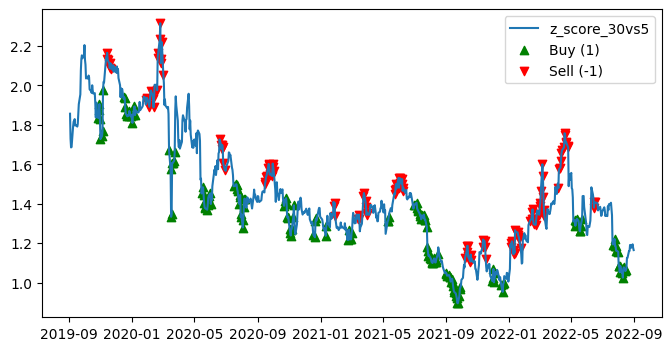

In [43]:
def plot_trade_signals(ratio_series):
    # With the graph above, we will want to trade the spread when the rolling moving average ratio moves outside the blue band.
    # If the value is above the band, that means that stock_1 (PEP) is overvalued compared to stock_2 (KO), so we will sell the spread, which means short stock_1 and long stock_2
    # If the value is below the band, that means that stock_1 (PEP) is undervalued compared to stock_2 (KO), so we will buy the spread, which means long stock_1 and short stock_2
    mavg_5_day = ratio_series.rolling(window=5).mean()

    # 30 day moving avg represents our historical mean
    mavg_30_day = ratio_series.rolling(window=30).mean()
    std_30_day = ratio_series.rolling(window=30).std()
    z_score_30vs5 = (mavg_5_day - mavg_30_day) / std_30_day

    trades = ratio_series.copy()
    # when the z-score is above 1, sell the spread
    trades[z_score_30vs5 > 1] = -1
    # when the z-score is below -1, buy the spread
    trades[z_score_30vs5 < -1] = 1
    trades[(z_score_30vs5 >= -1) & (z_score_30vs5 <= 1) |
           np.isnan(z_score_30vs5)] = 0  # otherwise, do nothing

    # TO DO: add a stop loss if this gets too far away from the mean. Maybe 3.5 SDs away?

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(ratio_series, label='z_score_30vs5')
    ax.scatter(ratio_series.index[trades == 1], ratio_series[trades == 1],
               color='green', marker='^', label='Buy (1)')
    ax.scatter(ratio_series.index[trades == -1], ratio_series[trades == -1],
               color='red', marker='v', label='Sell (-1)')
    ax.legend()
    plt.show()


plot_trade_signals(train_stock_one_price_series / train_stock_two_price_series)